## ACC: Predicting gym injuries

#### Step-by-Step Implementation in Python
     
The following code demonstrates:
  1. Import required packages
  2. Data ingestion and cleaning
  3. Basic exploratory data analysis (EDA)
  4. Feature engineering
  5. Train/test split
  6. Model building (using Random Forest Classifier)
  7. Model evaluation
  8. Ranking individuals by predicted risk
  9. Display charts for insights



In [1]:
# Required packages 
# -------------------------------------------------------------
# pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# !pip install imbalanced-learn

1. IMPORT REQUIRED PACKAGES


In [2]:
# 1. IMPORT REQUIRED PACKAGES
# -------------------------------------------------------------
import pandas as pd
import numpy as np

# For EDA and plotting (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# For encoding categorical variables
from sklearn.preprocessing import LabelEncoder

2. DATA INGESTION


In [3]:
# 2. DATA INGESTION
# -------------------------------------------------------------
# Read the dataset 
gym_injuries_df = pd.read_csv("DataForExercise.csv")

3. INITIAL DATA INSPECTION & CLEANING

In [4]:
# 3. INITIAL DATA INSPECTION & CLEANING
# -------------------------------------------------------------
# Check the first few rows
print(gym_injuries_df.head())

# Inspect basic info (column names, dtypes, missing values)
print(gym_injuries_df.info())

# let's rename our target variable (y) with a better name (outcome)
gym_injuries_df.rename(columns={'y': 'outcome'}, inplace=True)

# Check the distribution of the target variable
print(gym_injuries_df['outcome'].value_counts())


   PersonACCId  age_at_extraction_date ethnicity_last_claim  \
0            1                    25.0             European   
1            2                    29.0                Maori   
2            3                    50.0             European   
3            4                    28.0             European   
4            5                    26.0      Other Ethnicity   

  location_tla_last_claim  work_last_claim  Areaunit_score  num_gym_all  \
0       Christchurch City      Medium Work             7.0            0   
1      Whangarei District  Very Heavy Work             1.0            2   
2                 Unknown   Sedentary Work             6.0            1   
3       Christchurch City      Medium Work             9.0            0   
4           Auckland City   Sedentary Work             3.0            2   

   num_wgt_all  back_sprain_all  neck_sprain_all  ...  lower_back_all  \
0            0                0                0  ...               0   
1            2          

In [5]:
# 3a. Handling missing data
# Some columns like 'work_last_claim' or 'Areaunit_score' may have NAs/Unknown.

# Fill numeric missing values with 0
numeric_cols = gym_injuries_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    gym_injuries_df[col] = gym_injuries_df[col].fillna(0)

# Fill categorical missing values with "Unknown"
categorical_cols = gym_injuries_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    gym_injuries_df[col] = gym_injuries_df[col].fillna('Unknown')

# 3b. Check for duplicates
# Check for and handle any duplicate records
print("Number of duplicate rows:", gym_injuries_df.duplicated().sum())

# If duplicates exist, drop them and keep first occurrence
if gym_injuries_df.duplicated().sum() > 0:
    gym_injuries_df.drop_duplicates(keep='first', inplace=True)
    print("Duplicates removed. New shape:", gym_injuries_df.shape)


#3c. check of any of teh numeric columns have null values
gym_injuries_df.isnull().sum()
    

Number of duplicate rows: 0


PersonACCId                0
age_at_extraction_date     0
ethnicity_last_claim       0
location_tla_last_claim    0
work_last_claim            0
Areaunit_score             0
num_gym_all                0
num_wgt_all                0
back_sprain_all            0
neck_sprain_all            0
rotator_sprain_all         0
shoulder_sprain_all        0
kneeleg_sprain_all         0
thoracic_sprain_all        0
hipthigh_sprain_all        0
arm_sprain_all             0
soft_tissue_all            0
lower_back_all             0
shoulder_all               0
neck_all                   0
knee_all                   0
high_leg_thigh_all         0
upper_back_spine_all       0
ankle_all                  0
fracture_all               0
acci_year                  0
outcome                    0
dtype: int64

In [6]:
# Check data types
gym_injuries_df.dtypes

PersonACCId                  int64
age_at_extraction_date     float64
ethnicity_last_claim        object
location_tla_last_claim     object
work_last_claim             object
Areaunit_score             float64
num_gym_all                  int64
num_wgt_all                  int64
back_sprain_all              int64
neck_sprain_all              int64
rotator_sprain_all           int64
shoulder_sprain_all          int64
kneeleg_sprain_all           int64
thoracic_sprain_all          int64
hipthigh_sprain_all          int64
arm_sprain_all             float64
soft_tissue_all              int64
lower_back_all               int64
shoulder_all                 int64
neck_all                     int64
knee_all                     int64
high_leg_thigh_all           int64
upper_back_spine_all         int64
ankle_all                    int64
fracture_all                 int64
acci_year                   object
outcome                     object
dtype: object

4. BASIC EXPLORATORY DATA ANALYSIS (EDA)

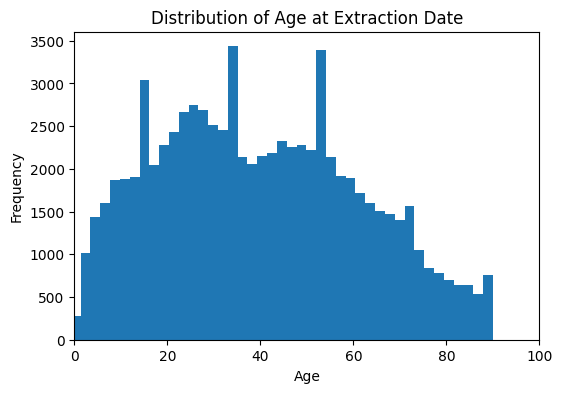

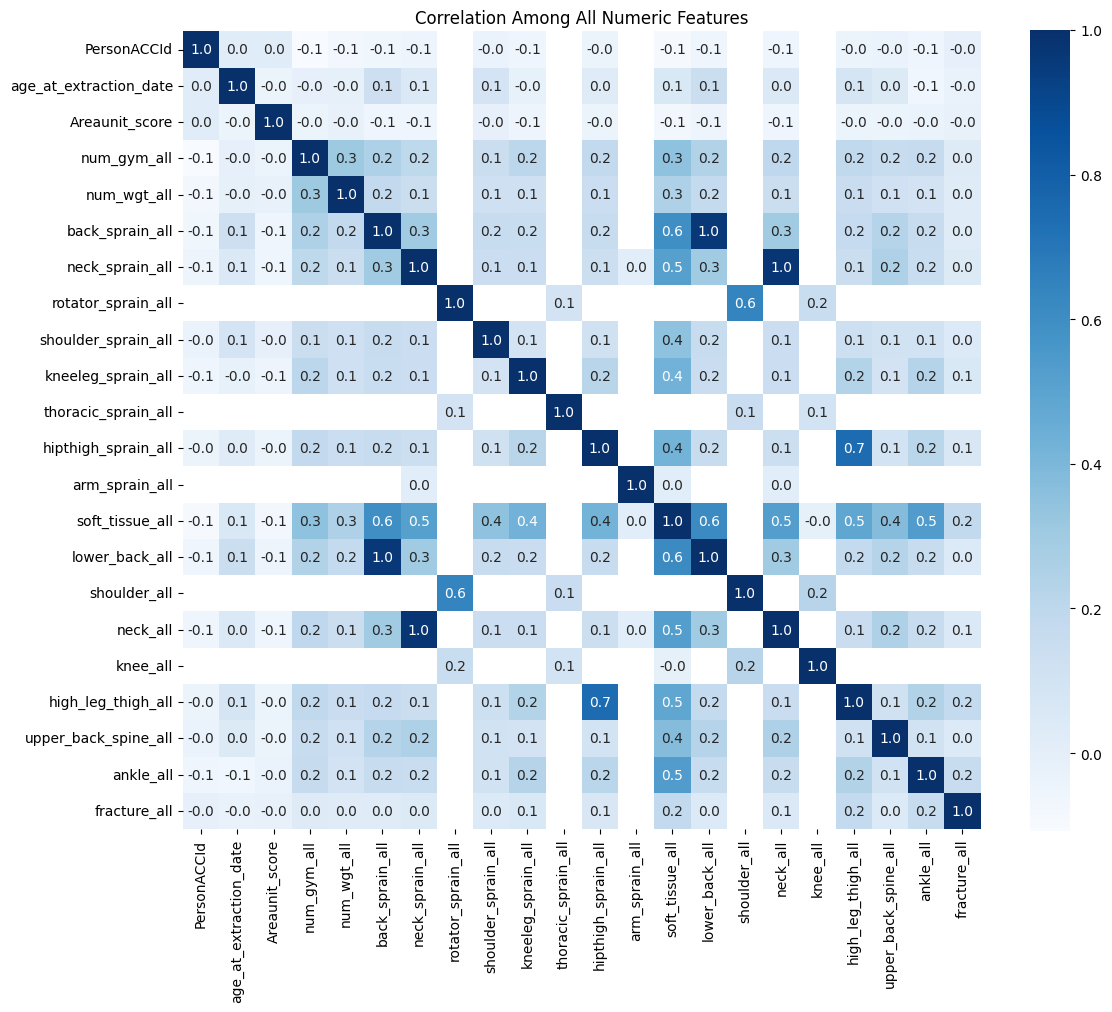

In [7]:
# 4. BASIC EXPLORATORY DATA ANALYSIS (EDA)
# -------------------------------------------------------------

# Example: distribution of age
plt.figure(figsize=(6, 4))
plt.hist(gym_injuries_df['age_at_extraction_date'], bins=90, range=(-100, 90))
plt.title('Distribution of Age at Extraction Date')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.show()

# Example: correlation heatmap of numeric features
# (May need to select a subset of columns if you have many "sprain_all" fields.)
numeric_subset = gym_injuries_df.select_dtypes(include=[np.number])
corr = numeric_subset.corr()

# Mask near-zero correlations
mask = np.abs(corr) < 0.01  # Mask values very close to 0
corr_masked = corr.mask(mask)

plt.figure(figsize=(12, 10))  # Increased figure size for better readability
sns.heatmap(corr_masked, annot=True, cmap='Blues', fmt='.1f', 
            mask=mask,  # Apply mask to hide near-zero correlations
            square=True)
plt.title('Correlation Among All Numeric Features')
plt.xticks(rotation=90, ha='center')  # Changed rotation to 90 degrees
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()




5. FEATURE ENGINEERING


Key Decisions

We have individuals with age anomaly values (-1047, 0 to - 15). 

We will drop records with age_at_extraction_date < 0 and age_at_extraction_date < 15.

Reason: By NZ's standards, individuals can legally go to gym unsupervised at 16 years of age.



Class Distribution:
outcome
N    64322
Y     3754
Name: count, dtype: int64

Percentage Distribution:
outcome
N    94.485575
Y     5.514425
Name: count, dtype: float64


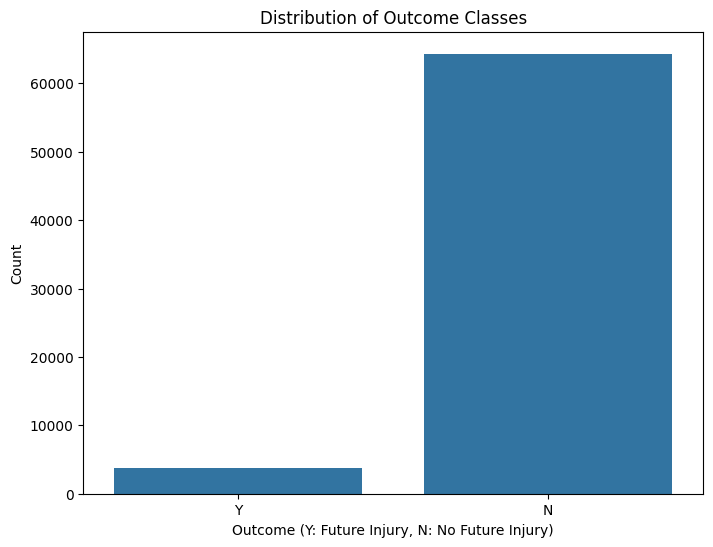

In [8]:
# 5. FEATURE ENGINEERING
# -------------------------------------------------------------

# exclude records with age_at_extraction_date < 0 and age_at_extraction_date < 15
gym_injuries_df = gym_injuries_df[gym_injuries_df['age_at_extraction_date'] > 15]

# Check class distribution of outcome variable
outcome_dist = gym_injuries_df['outcome'].value_counts()
print("\nClass Distribution:")
print(outcome_dist)
print("\nPercentage Distribution:")
print(outcome_dist / len(gym_injuries_df) * 100)

# Visualize the distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=gym_injuries_df, x='outcome')
plt.title('Distribution of Outcome Classes')
plt.xlabel('Outcome (Y: Future Injury, N: No Future Injury)')
plt.ylabel('Count')
plt.show()



As shown in the class distribution above, we have an imbalanced dataset with respect to the outcome variable.
To address this issue in step 7 (Model Building), we will use:
 1. Random Forest - which handles imbalanced data better than many other algorithms
 2. SMOTE (Synthetic Minority Over-sampling Technique) - to create synthetic samples of the minority class
    and balance our training data

This combined approach will help ensure our model learns patterns from both classes effectively,
despite the original imbalance in the data.

In [9]:
# Fill missing values with mode for numeric variable
# We used mode to highlight the most ocurring value for the deprivation zone 
gym_injuries_df['Areaunit_score'] = gym_injuries_df['Areaunit_score'].fillna(gym_injuries_df['Areaunit_score'].mode()[0])

# Label-encode categorical features (e.g., ethnicity, location, work type)
# Create dummy variables for ethnicity since it's categorical with no ordinal relationship
ethnicity_dummies = pd.get_dummies(gym_injuries_df['ethnicity_last_claim'], prefix='ethnicity')
gym_injuries_df = pd.concat([gym_injuries_df, ethnicity_dummies], axis=1)

# Create dummy variables for location_tla_last_claim
location_dummies = pd.get_dummies(gym_injuries_df['location_tla_last_claim'], prefix='location')
gym_injuries_df = pd.concat([gym_injuries_df, location_dummies], axis=1)

# Create dummy variables for work_last_claim, replacing NA with "Not Stated"
gym_injuries_df['work_last_claim'] = gym_injuries_df['work_last_claim'].fillna('Not Stated')
work_dummies = pd.get_dummies(gym_injuries_df['work_last_claim'], prefix='work')
gym_injuries_df = pd.concat([gym_injuries_df, work_dummies], axis=1)

# Encode accident year. This gives us a value that is closer to the current year to determine recency of claim.
# The higher the value, the more recent the claim thus higher risk.
le = LabelEncoder()
gym_injuries_df['acci_year'] = le.fit_transform(gym_injuries_df['acci_year'])
encoders = {'acci_year': le}

# Drop original categorical columns since we now have dummy variables
gym_injuries_df = gym_injuries_df.drop(['ethnicity_last_claim', 'location_tla_last_claim', 'work_last_claim'], axis=1)

# Create a total injuries feature by summing all prior injuries
# This gives us a total number of injuries for each individual.
injury_cols = [
    'num_gym_all', 'num_wgt_all', 'back_sprain_all', 'neck_sprain_all',
    'rotator_sprain_all', 'shoulder_sprain_all', 'kneeleg_sprain_all',
    'thoracic_sprain_all', 'hipthigh_sprain_all', 'arm_sprain_all',
    'soft_tissue_all', 'lower_back_all', 'shoulder_all', 'neck_all',
    'knee_all', 'high_leg_thigh_all', 'upper_back_spine_all',
    'ankle_all', 'fracture_all'
]


# Create a total injuries feature by summing all prior injuries
gym_injuries_df['total_past_injuries'] = gym_injuries_df[injury_cols].sum(axis=1)

# Convert the target "response" from Y/N to 1/0
gym_injuries_df['response_binary'] = gym_injuries_df['outcome'].map({'Y': 1, 'N': 0})

6. SPLIT DATA INTO FEATURES (X) AND TARGET (y), THEN TRAIN/TEST


In [10]:
# 6. SPLIT DATA INTO FEATURES (X) AND TARGET (y), THEN TRAIN/TEST
# -------------------------------------------------------------

# Import required libraries
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define the feature columns
feature_cols = ['age_at_extraction_date', 'Areaunit_score',
       'num_gym_all', 'num_wgt_all', 'back_sprain_all', 'neck_sprain_all',
       'rotator_sprain_all', 'shoulder_sprain_all', 'kneeleg_sprain_all',
       'thoracic_sprain_all', 'hipthigh_sprain_all', 'arm_sprain_all',
       'soft_tissue_all', 'lower_back_all', 'shoulder_all', 'neck_all',
       'knee_all', 'high_leg_thigh_all', 'upper_back_spine_all', 'ankle_all',
       'fracture_all', 'acci_year', 'ethnicity_Asian', 'ethnicity_European',
       'ethnicity_Maori', 'ethnicity_Other Ethnicity', 'ethnicity_Pacific Peoples',
       'ethnicity_Residual Categories', 'location_Auckland City',
       'location_Christchurch City', 'location_Dunedin City',
       'location_Hamilton City', 'location_Manukau City',
       'location_North Shore City', 'location_Tauranga City',
       'location_Unknown', 'location_Wellington City',
       'location_Whangarei District', 'work_Heavy Work', 'work_Light Work',
       'work_Medium Work', 'work_Not Stated', 'work_Sedentary Work',
       'work_Unknown', 'work_Very Heavy Work', 'total_past_injuries'
]

# Prepare features and target
X = gym_injuries_df[feature_cols]
y = gym_injuries_df['response_binary']

7. MODEL BUILDING & TRAINING (RANDOM FOREST CLASSIFIER)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     12880
           1       0.38      0.15      0.21       736

    accuracy                           0.94     13616
   macro avg       0.67      0.57      0.59     13616
weighted avg       0.92      0.94      0.93     13616

AUC: 0.791


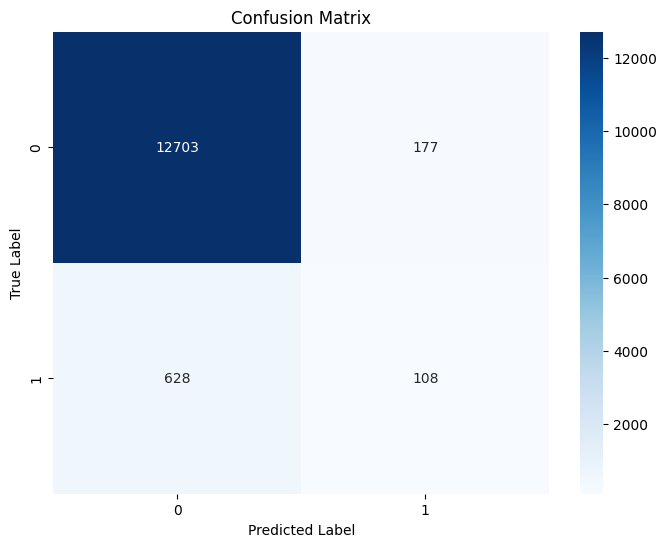

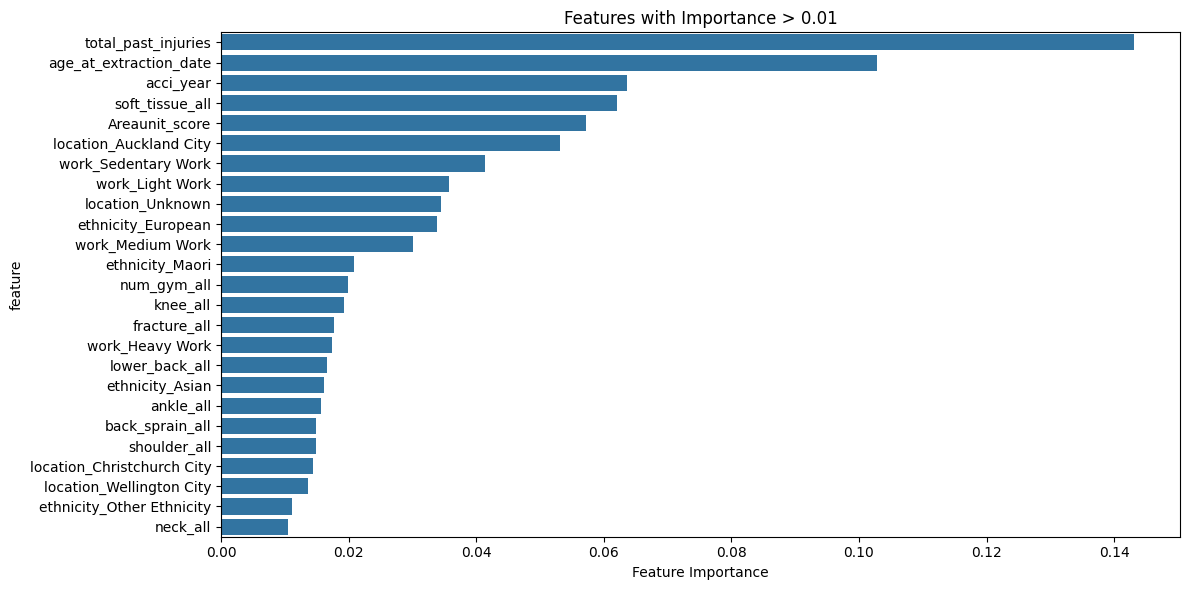

In [11]:
# 7. MODEL BUILDING & TRAINING (RANDOM FOREST CLASSIFIER)
# -------------------------------------------------------------
# For demonstration, we are using Random Forest Classifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train model
model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]


# Print classification report and AUC
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance plot
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance[feature_importance['importance'] > 0.01])
plt.title('Features with Importance > 0.01')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

8. MODEL EVALUATION


In [12]:
# 8. MODEL EVALUATION
# -------------------------------------------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Predicted probability of class=1

# Print a classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate and print AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc_score:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     12880
           1       0.38      0.15      0.21       736

    accuracy                           0.94     13616
   macro avg       0.67      0.57      0.59     13616
weighted avg       0.92      0.94      0.93     13616

AUC: 0.791
Confusion Matrix:
 [[12703   177]
 [  628   108]]


Overview
Our model attempts to predict whether someone will have a future gym injury based on various factors. Out of 13,616 total cases analyzed, there were 12,880 non-injury cases and 736 injury cases.

What the Model Does Well
- Very good at identifying people who won't have injuries (99% accuracy)
- Overall accuracy of 94%, which seems high but needs context
- Good at avoiding false alarms for non-injury cases (95% precision)

Where the Model Struggles
- Only catches 15% of actual injuries (108 out of 736)
- Misses 628 injuries, classifying them as non-injuries

This is the most concerning aspect from a safety perspective.
Injury Predictions:
- When the model predicts an injury, it's right only 38% of the time eventhough we have used SMOTE to balance the data.
- Out of 285 injury predictions (177 + 108), only 108 were correct
- A further finetuning of the model is required to improve the accuracy of injury predictions.


9. RANK INDIVIDUALS BY PREDICTED RISK AND DISPLAY CHARTS FOR INSIGHTS

In [13]:
# 9. RANK INDIVIDUALS BY PREDICTED RISK
# -------------------------------------------------------------
# Now that the model is trained, we can generate risk scores for ALL data
# (or just the test set if you prefer). We'll use the entire dataset here
# as an example of how you'd rank everyone.

gym_injuries_df['predicted_prob'] = model.predict_proba(X)[:, 1]

# Sort by predicted probability of experiencing a gym injury (descending)
gym_injuries_df_sorted = gym_injuries_df.sort_values(by='predicted_prob', ascending=False)

# Select the top 500 individuals
top_500 = gym_injuries_df_sorted.head(500)

# Show some columns of interest
print(top_500[['PersonACCId', 'predicted_prob', 'num_gym_all', 'num_wgt_all', 'total_past_injuries']].head(10))

# This list (top_500) would be your recommended group for the free PT sessions.

      PersonACCId  predicted_prob  num_gym_all  num_wgt_all  \
597           598            1.00            2            0   
1942         1943            1.00            2            3   
528           529            1.00            0            0   
560           561            1.00            6            6   
1454         1455            1.00            5            0   
3832         3833            1.00            0            0   
353           354            1.00            0            0   
3826         3827            0.99            4            0   
3859         3860            0.99            6            4   
1578         1579            0.99            3            1   

      total_past_injuries  
597                  31.0  
1942                 37.0  
528                   2.0  
560                  54.0  
1454                 32.0  
3832                  2.0  
353                   7.0  
3826                 45.0  
3859                 79.0  
1578                 16.0 

In [14]:
gym_injuries_df.head(10)

,PersonACCId,age_at_extraction_date,Areaunit_score,num_gym_all,num_wgt_all,back_sprain_all,neck_sprain_all,rotator_sprain_all,shoulder_sprain_all,kneeleg_sprain_all,...,work_Heavy Work,work_Light Work,work_Medium Work,work_Not Stated,work_Sedentary Work,work_Unknown,work_Very Heavy Work,total_past_injuries,response_binary,predicted_prob
0,1,25.0,7.0,0,0,0,0,0,0,0,...,False,False,True,False,False,False,False,3.0,1,0.60
1,2,29.0,1.0,2,2,5,6,0,4,5,...,False,False,False,False,False,False,True,112.0,1,0.98
2,3,50.0,6.0,1,1,1,0,0,0,0,...,False,False,False,False,True,False,False,9.0,1,0.82
3,4,28.0,9.0,0,0,1,0,0,0,0,...,False,False,True,False,False,False,False,4.0,1,0.66
4,5,26.0,3.0,2,1,1,0,0,0,2,...,False,False,False,False,True,False,False,11.0,1,0.65
5,6,16.0,2.0,0,0,0,1,0,0,1,...,False,False,False,False,True,False,False,9.0,1,0.89
6,7,34.0,7.0,0,0,0,1,0,0,0,...,False,False,False,False,True,False,False,3.0,1,0.09
7,8,26.0,10.0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,2.0,1,0.72
8,9,32.0,6.0,3,0,1,0,0,0,0,...,False,False,False,False,True,False,False,18.0,1,0.93
9,10,17.0,0.0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,5.0,1,0.79


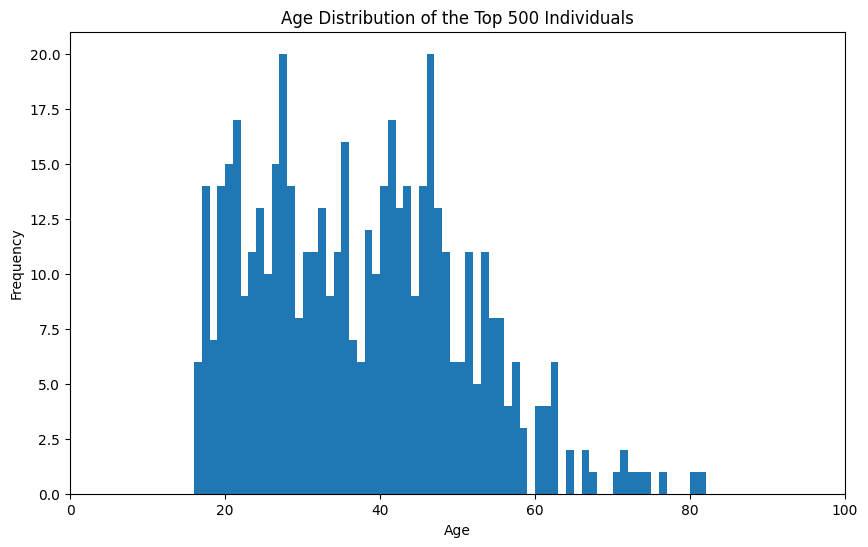

In [15]:
# Distribution of teh top 500 individuals by age
plt.figure(figsize=(10, 6))
plt.hist(top_500['age_at_extraction_date'], bins=90, range=(0, 90))
plt.title('Age Distribution of the Top 500 Individuals')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.show()


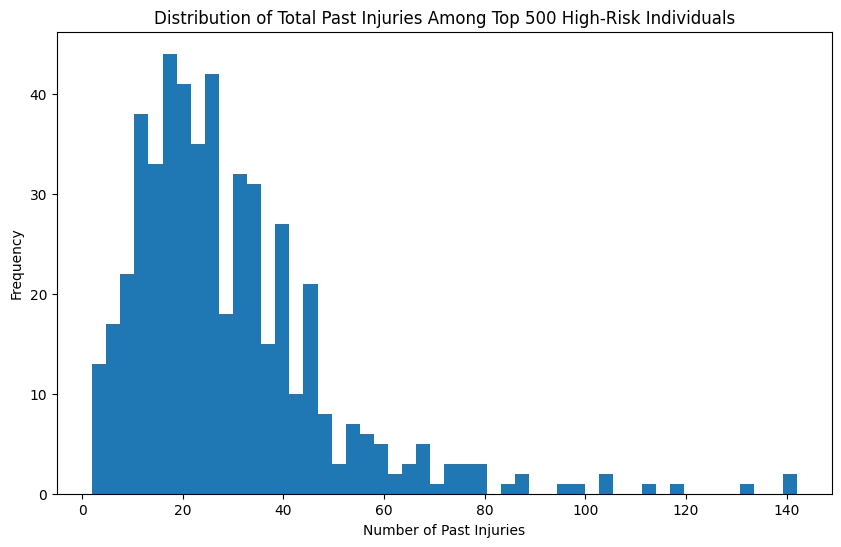

In [16]:
# chart of the top 500 individuals by total past injuries
plt.figure(figsize=(10, 6))
plt.hist(top_500['total_past_injuries'], bins=50)
plt.title('Distribution of Total Past Injuries Among Top 500 High-Risk Individuals')
plt.xlabel('Number of Past Injuries')
plt.ylabel('Frequency')
plt.show()

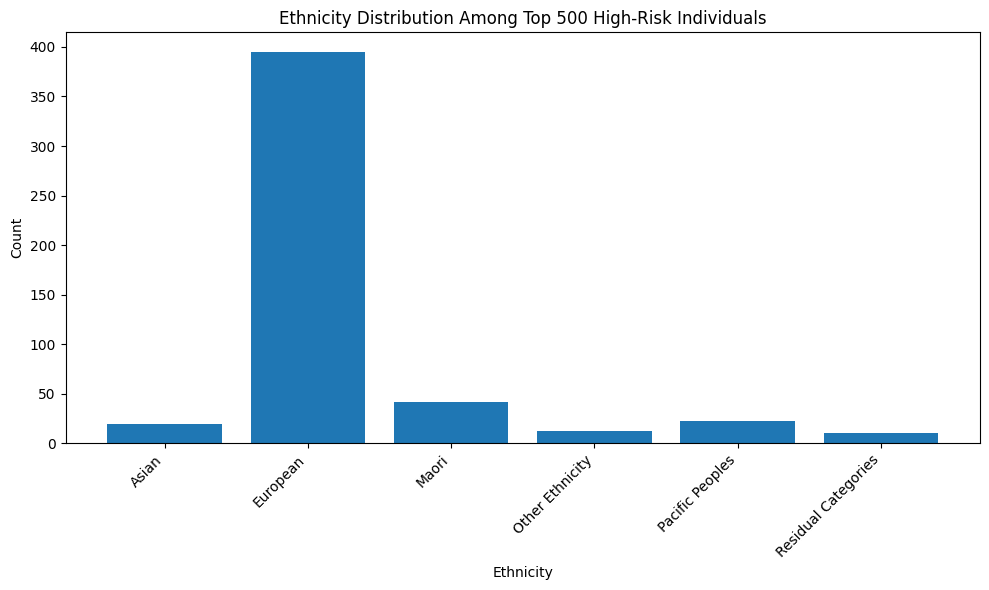

In [17]:
# chart of ethnicity distribution among top 500 high-risk individuals
ethnicity_cols = [col for col in top_500.columns if col.startswith('ethnicity_')]
ethnicity_counts = top_500[ethnicity_cols].sum()

plt.figure(figsize=(10, 6))
plt.bar(ethnicity_counts.index.str.replace('ethnicity_', ''), ethnicity_counts.values)
plt.title('Ethnicity Distribution Among Top 500 High-Risk Individuals')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

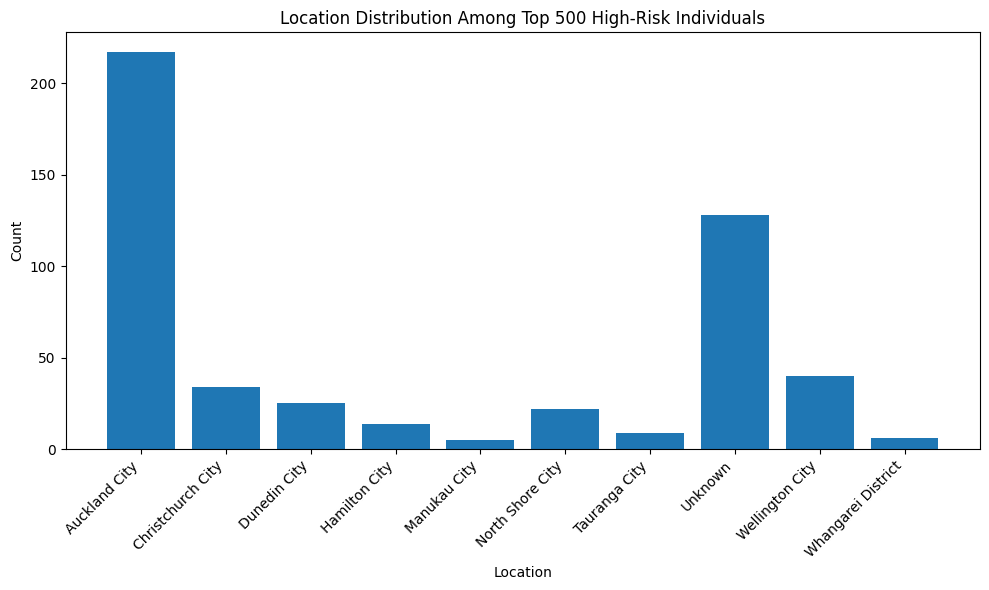

In [18]:
# chart of location distribution among top 500 high-risk individuals
location_cols = [col for col in top_500.columns if col.startswith('location_')]
location_counts = top_500[location_cols].sum()

plt.figure(figsize=(10, 6))
plt.bar(location_counts.index.str.replace('location_', ''), location_counts.values)
plt.title('Location Distribution Among Top 500 High-Risk Individuals')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


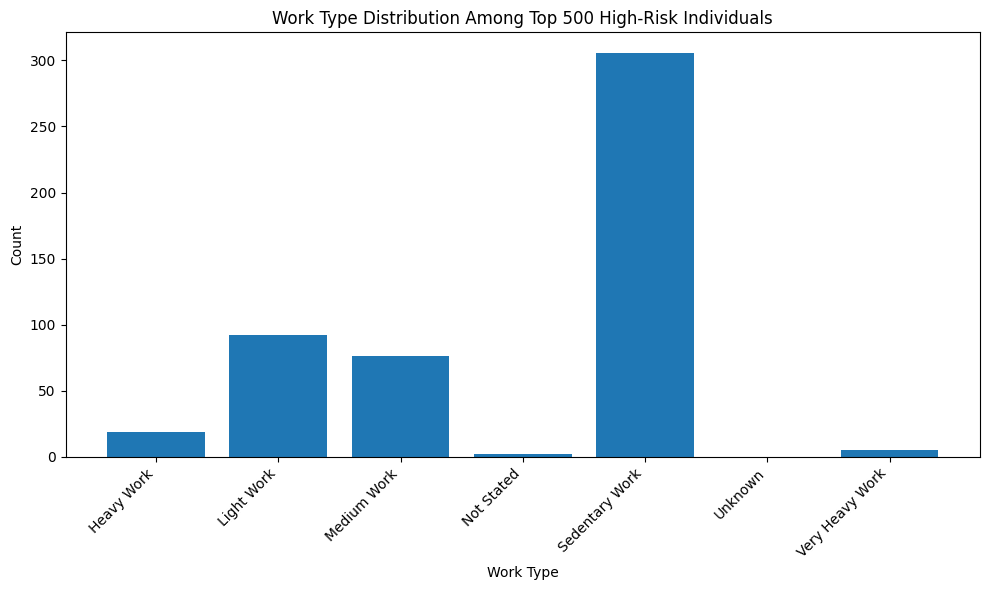

In [19]:
# chart of work type distribution among top 500 high-risk individuals
work_cols = [col for col in top_500.columns if col.startswith('work_')]
work_counts = top_500[work_cols].sum()

plt.figure(figsize=(10, 6))
plt.bar(work_counts.index.str.replace('work_', ''), work_counts.values)
plt.title('Work Type Distribution Among Top 500 High-Risk Individuals')
plt.xlabel('Work Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
